## 1. Import bibliotek

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Przetwarzanie sygnałów
import neurokit2 as nk
from scipy import signal as scipy_signal
from scipy.stats import skew, kurtosis

# Machine Learning
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

# Ustawienia
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Biblioteki załadowane!")

✅ Biblioteki załadowane!


In [5]:
# Konfiguracja
DATA_PATH = Path("/home/milosz/Desktop/studia/afektywna/Affective-Computing/archive/WESAD")
SUBJECTS = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

# Sampling rates
WRIST_SR = {'BVP': 64, 'EDA': 4, 'TEMP': 4}
CHEST_SR = 700  # RespiBAN sampling rate

# Parametry okien
WINDOW_SIZE = 60  # sekund
WINDOW_SHIFT = 30  # sekund

print(f"📁 Ścieżka: {DATA_PATH}")
print(f"👥 Uczestnicy: {len(SUBJECTS)}")

📁 Ścieżka: /home/milosz/Desktop/studia/afektywna/Affective-Computing/archive/WESAD
👥 Uczestnicy: 15


## 2. Wczytywanie danych i podgląd struktury

In [6]:
def load_subject_data(subject_id: str) -> dict:
    """Wczytuje dane uczestnika z pliku .pkl"""
    file_path = DATA_PATH / subject_id / f"{subject_id}.pkl"
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

# Podgląd struktury danych
sample = load_subject_data('S2')

print("📊 SYGNAŁY Z NADGARSTKA (Empatica E4):")
for key, value in sample['signal']['wrist'].items():
    print(f"   {key}: shape = {value.shape}")

print("\n📊 SYGNAŁY Z KLATKI PIERSIOWEJ (RespiBAN):")
for key, value in sample['signal']['chest'].items():
    print(f"   {key}: shape = {value.shape}")

📊 SYGNAŁY Z NADGARSTKA (Empatica E4):
   ACC: shape = (194528, 3)
   BVP: shape = (389056, 1)
   EDA: shape = (24316, 1)
   TEMP: shape = (24316, 1)

📊 SYGNAŁY Z KLATKI PIERSIOWEJ (RespiBAN):
   ACC: shape = (4255300, 3)
   ECG: shape = (4255300, 1)
   EMG: shape = (4255300, 1)
   EDA: shape = (4255300, 1)
   Temp: shape = (4255300, 1)
   Resp: shape = (4255300, 1)


## 3. Wizualizacja różnic w jakości sygnałów

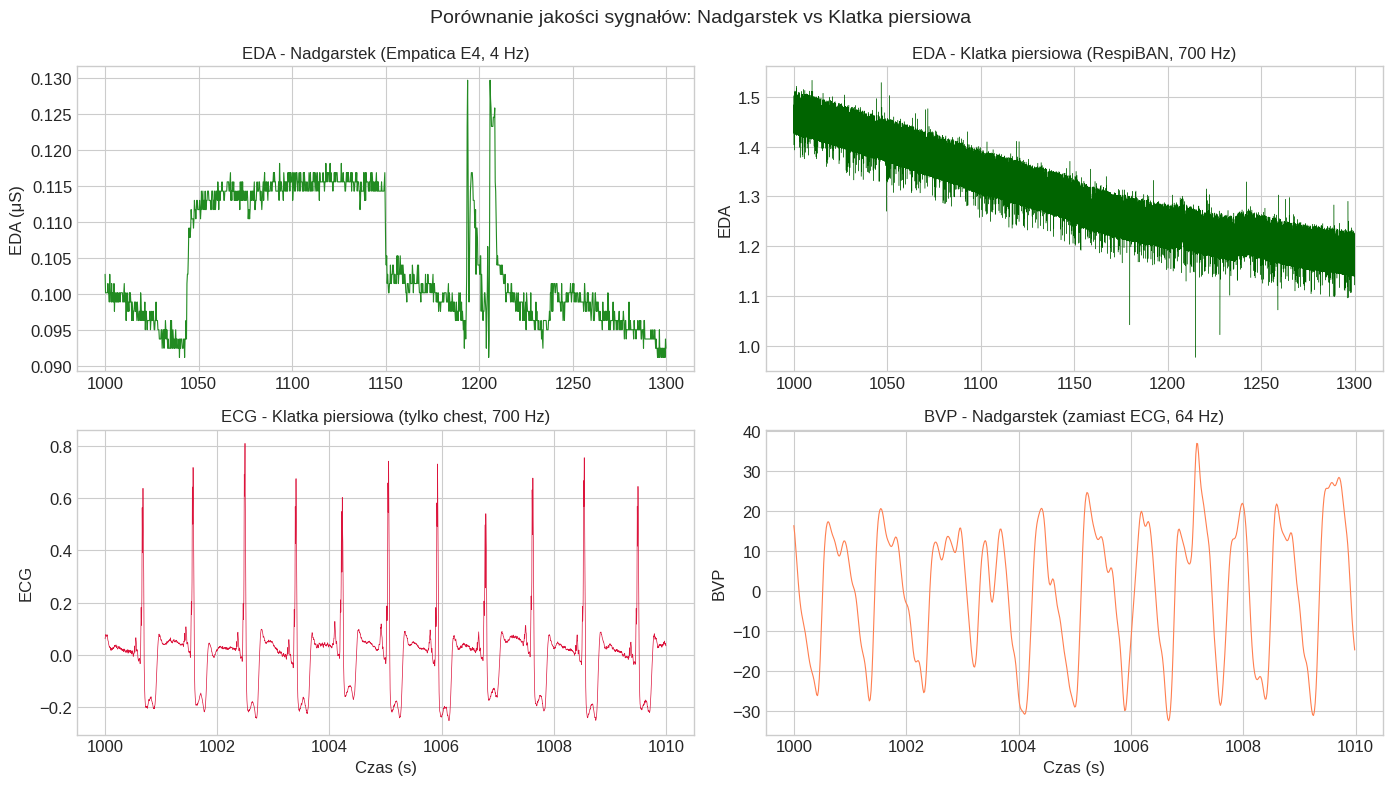


📌 Obserwacje:
   - Klatka: wyższa częstotliwość próbkowania (700 Hz vs 4-64 Hz)
   - Klatka: bezpośredni ECG zamiast optycznego BVP
   - Nadgarstek: więcej szumów, artefakty ruchu


In [7]:
# Porównanie sygnałów EDA z obu urządzeń
sample = load_subject_data('S2')

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# EDA - nadgarstek vs klatka
start_sec, duration = 1000, 300

# Wrist EDA
eda_wrist = sample['signal']['wrist']['EDA'].flatten()
sr_wrist = 4
time_wrist = np.arange(start_sec*sr_wrist, (start_sec+duration)*sr_wrist) / sr_wrist
axes[0, 0].plot(time_wrist, eda_wrist[start_sec*sr_wrist:(start_sec+duration)*sr_wrist], 
                color='forestgreen', linewidth=0.8)
axes[0, 0].set_title('EDA - Nadgarstek (Empatica E4, 4 Hz)', fontsize=12)
axes[0, 0].set_ylabel('EDA (μS)')

# Chest EDA
eda_chest = sample['signal']['chest']['EDA'].flatten()
sr_chest = 700
time_chest = np.arange(start_sec*sr_chest, (start_sec+duration)*sr_chest) / sr_chest
axes[0, 1].plot(time_chest, eda_chest[start_sec*sr_chest:(start_sec+duration)*sr_chest], 
                color='darkgreen', linewidth=0.3)
axes[0, 1].set_title('EDA - Klatka piersiowa (RespiBAN, 700 Hz)', fontsize=12)
axes[0, 1].set_ylabel('EDA')

# ECG (tylko klatka)
ecg_chest = sample['signal']['chest']['ECG'].flatten()
time_ecg = np.arange(start_sec*sr_chest, (start_sec+10)*sr_chest) / sr_chest  # 10 sekund
axes[1, 0].plot(time_ecg, ecg_chest[start_sec*sr_chest:(start_sec+10)*sr_chest], 
                color='crimson', linewidth=0.5)
axes[1, 0].set_title('ECG - Klatka piersiowa (tylko chest, 700 Hz)', fontsize=12)
axes[1, 0].set_ylabel('ECG')
axes[1, 0].set_xlabel('Czas (s)')

# BVP (nadgarstek) - zamiennik ECG
bvp_wrist = sample['signal']['wrist']['BVP'].flatten()
sr_bvp = 64
time_bvp = np.arange(start_sec*sr_bvp, (start_sec+10)*sr_bvp) / sr_bvp
axes[1, 1].plot(time_bvp, bvp_wrist[start_sec*sr_bvp:(start_sec+10)*sr_bvp], 
                color='coral', linewidth=0.8)
axes[1, 1].set_title('BVP - Nadgarstek (zamiast ECG, 64 Hz)', fontsize=12)
axes[1, 1].set_ylabel('BVP')
axes[1, 1].set_xlabel('Czas (s)')

plt.suptitle('Porównanie jakości sygnałów: Nadgarstek vs Klatka piersiowa', fontsize=14)
plt.tight_layout()
plt.show()

print("\n📌 Obserwacje:")
print("   - Klatka: wyższa częstotliwość próbkowania (700 Hz vs 4-64 Hz)")
print("   - Klatka: bezpośredni ECG zamiast optycznego BVP")
print("   - Nadgarstek: więcej szumów, artefakty ruchu")

## 4. Ekstrakcja cech - NADGARSTEK (Wrist)

In [8]:
def extract_wrist_features(data: dict, window_start: int, window_size: int = 60) -> dict:
    """
    Ekstrakcja cech z sygnałów nadgarstkowych (Empatica E4)
    """
    features = {}
    chest_sr = 700
    
    # === EDA (4 Hz) ===
    try:
        eda = data['signal']['wrist']['EDA'].flatten()
        ratio = 4 / chest_sr
        start_idx = int(window_start * ratio)
        end_idx = int((window_start + window_size * chest_sr) * ratio)
        eda_window = eda[start_idx:end_idx]
        
        if len(eda_window) > 8:
            features['wrist_eda_mean'] = np.mean(eda_window)
            features['wrist_eda_std'] = np.std(eda_window)
            features['wrist_eda_min'] = np.min(eda_window)
            features['wrist_eda_max'] = np.max(eda_window)
            features['wrist_eda_range'] = features['wrist_eda_max'] - features['wrist_eda_min']
            
            # NeuroKit2 processing
            eda_processed = nk.eda_process(eda_window, sampling_rate=4)
            if 'EDA_Tonic' in eda_processed[0].columns:
                features['wrist_eda_tonic_mean'] = eda_processed[0]['EDA_Tonic'].mean()
            if 'EDA_Phasic' in eda_processed[0].columns:
                features['wrist_eda_phasic_mean'] = eda_processed[0]['EDA_Phasic'].mean()
            if 'SCR_Peaks' in eda_processed[0].columns:
                features['wrist_scr_count'] = eda_processed[0]['SCR_Peaks'].sum()
    except:
        pass
    
    # === BVP (64 Hz) → HR/HRV ===
    try:
        bvp = data['signal']['wrist']['BVP'].flatten()
        ratio = 64 / chest_sr
        start_idx = int(window_start * ratio)
        end_idx = int((window_start + window_size * chest_sr) * ratio)
        bvp_window = bvp[start_idx:end_idx]
        
        if len(bvp_window) > 320:  # min 5 sekund
            features['wrist_bvp_mean'] = np.mean(bvp_window)
            features['wrist_bvp_std'] = np.std(bvp_window)
            
            ppg_processed = nk.ppg_process(bvp_window, sampling_rate=64)
            if 'PPG_Rate' in ppg_processed[0].columns:
                hr = ppg_processed[0]['PPG_Rate'].dropna()
                if len(hr) > 0:
                    features['wrist_hr_mean'] = hr.mean()
                    features['wrist_hr_std'] = hr.std()
            
            # HRV
            peaks = ppg_processed[0][ppg_processed[0]['PPG_Peaks'] == 1].index.values
            if len(peaks) > 3:
                rr = np.diff(peaks) / 64 * 1000
                features['wrist_hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr)**2))
                features['wrist_hrv_sdnn'] = np.std(rr)
    except:
        pass
    
    # === TEMP (4 Hz) ===
    try:
        temp = data['signal']['wrist']['TEMP'].flatten()
        ratio = 4 / chest_sr
        start_idx = int(window_start * ratio)
        end_idx = int((window_start + window_size * chest_sr) * ratio)
        temp_window = temp[start_idx:end_idx]
        
        if len(temp_window) > 4:
            features['wrist_temp_mean'] = np.mean(temp_window)
            features['wrist_temp_std'] = np.std(temp_window)
    except:
        pass
    
    return features

print("✅ Funkcja ekstrakcji cech z nadgarstka zdefiniowana!")

✅ Funkcja ekstrakcji cech z nadgarstka zdefiniowana!


## 5. Ekstrakcja cech - KLATKA PIERSIOWA (Chest)

In [9]:
def extract_chest_features(data: dict, window_start: int, window_size: int = 60) -> dict:
    """
    Ekstrakcja cech z sygnałów z klatki piersiowej (RespiBAN)
    """
    features = {}
    chest_sr = 700
    
    start_idx = window_start
    end_idx = window_start + window_size * chest_sr
    
    # === ECG (700 Hz) → HR/HRV ===
    try:
        ecg = data['signal']['chest']['ECG'].flatten()
        ecg_window = ecg[start_idx:end_idx]
        
        if len(ecg_window) > chest_sr * 5:
            # Przetwarzanie ECG
            ecg_processed = nk.ecg_process(ecg_window, sampling_rate=chest_sr)
            
            if 'ECG_Rate' in ecg_processed[0].columns:
                hr = ecg_processed[0]['ECG_Rate'].dropna()
                if len(hr) > 0:
                    features['chest_hr_mean'] = hr.mean()
                    features['chest_hr_std'] = hr.std()
                    features['chest_hr_min'] = hr.min()
                    features['chest_hr_max'] = hr.max()
            
            # HRV z R-peaks
            r_peaks = ecg_processed[1]['ECG_R_Peaks']
            if len(r_peaks) > 3:
                rr = np.diff(r_peaks) / chest_sr * 1000
                features['chest_hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr)**2))
                features['chest_hrv_sdnn'] = np.std(rr)
                features['chest_hrv_mean_rr'] = np.mean(rr)
                features['chest_hrv_pnn50'] = np.sum(np.abs(np.diff(rr)) > 50) / len(rr) * 100
    except:
        pass
    
    # === EDA (700 Hz) ===
    try:
        eda = data['signal']['chest']['EDA'].flatten()
        eda_window = eda[start_idx:end_idx]
        
        if len(eda_window) > chest_sr:
            features['chest_eda_mean'] = np.mean(eda_window)
            features['chest_eda_std'] = np.std(eda_window)
            features['chest_eda_min'] = np.min(eda_window)
            features['chest_eda_max'] = np.max(eda_window)
            
            # Downsampling do 4 Hz dla NeuroKit
            eda_downsampled = scipy_signal.resample(eda_window, len(eda_window) // 175)
            eda_processed = nk.eda_process(eda_downsampled, sampling_rate=4)
            if 'SCR_Peaks' in eda_processed[0].columns:
                features['chest_scr_count'] = eda_processed[0]['SCR_Peaks'].sum()
    except:
        pass
    
    # === TEMP (700 Hz) ===
    try:
        temp = data['signal']['chest']['Temp'].flatten()
        temp_window = temp[start_idx:end_idx]
        
        if len(temp_window) > chest_sr:
            features['chest_temp_mean'] = np.mean(temp_window)
            features['chest_temp_std'] = np.std(temp_window)
    except:
        pass
    
    # === RESP (700 Hz) - oddychanie ===
    try:
        resp = data['signal']['chest']['Resp'].flatten()
        resp_window = resp[start_idx:end_idx]
        
        if len(resp_window) > chest_sr * 5:
            features['chest_resp_mean'] = np.mean(resp_window)
            features['chest_resp_std'] = np.std(resp_window)
            
            # Częstość oddechów
            resp_processed = nk.rsp_process(resp_window, sampling_rate=chest_sr)
            if 'RSP_Rate' in resp_processed[0].columns:
                rr_rate = resp_processed[0]['RSP_Rate'].dropna()
                if len(rr_rate) > 0:
                    features['chest_resp_rate_mean'] = rr_rate.mean()
                    features['chest_resp_rate_std'] = rr_rate.std()
    except:
        pass
    
    return features

print("✅ Funkcja ekstrakcji cech z klatki piersiowej zdefiniowana!")

✅ Funkcja ekstrakcji cech z klatki piersiowej zdefiniowana!


## 6. Przetwarzanie wszystkich uczestników

In [10]:
def get_majority_label(labels: np.ndarray, window_start: int, window_size: int, chest_sr: int = 700) -> int:
    """Zwraca dominującą etykietę w oknie"""
    window_end = window_start + window_size * chest_sr
    window_labels = labels[window_start:window_end]
    valid = window_labels[(window_labels >= 1) & (window_labels <= 4)]
    if len(valid) == 0:
        return 0
    unique, counts = np.unique(valid, return_counts=True)
    return unique[np.argmax(counts)]


def process_all_subjects():
    """Przetwarza wszystkich uczestników i zwraca DataFrame dla obu źródeł"""
    
    all_wrist = []
    all_chest = []
    
    for subject in tqdm(SUBJECTS, desc="Przetwarzanie uczestników"):
        try:
            data = load_subject_data(subject)
            labels = data['label'].flatten()
            chest_sr = 700
            total_samples = len(labels)
            
            window_start = 0
            while window_start + WINDOW_SIZE * chest_sr < total_samples:
                label = get_majority_label(labels, window_start, WINDOW_SIZE, chest_sr)
                
                if label == 0:  # pomiń niezdefiniowane
                    window_start += WINDOW_SHIFT * chest_sr
                    continue
                
                # Ekstrakcja cech z obu źródeł
                wrist_feat = extract_wrist_features(data, window_start, WINDOW_SIZE)
                chest_feat = extract_chest_features(data, window_start, WINDOW_SIZE)
                
                if wrist_feat and chest_feat:
                    wrist_feat['label'] = label
                    wrist_feat['subject'] = subject
                    wrist_feat['is_stress'] = 1 if label == 2 else 0
                    
                    chest_feat['label'] = label
                    chest_feat['subject'] = subject
                    chest_feat['is_stress'] = 1 if label == 2 else 0
                    
                    all_wrist.append(wrist_feat)
                    all_chest.append(chest_feat)
                
                window_start += WINDOW_SHIFT * chest_sr
                
        except Exception as e:
            print(f"❌ {subject}: {e}")
    
    return pd.DataFrame(all_wrist), pd.DataFrame(all_chest)


print("🔄 Rozpoczynam przetwarzanie...")
df_wrist, df_chest = process_all_subjects()

print(f"\n✅ Nadgarstek: {len(df_wrist)} okien, {df_wrist.shape[1]} kolumn")
print(f"✅ Klatka: {len(df_chest)} okien, {df_chest.shape[1]} kolumn")

🔄 Rozpoczynam przetwarzanie...


Przetwarzanie uczestników: 100%|██████████| 15/15 [13:23<00:00, 53.54s/it]


✅ Nadgarstek: 1648 okien, 19 kolumn
✅ Klatka: 1648 okien, 22 kolumn


In [11]:
# Podgląd cech
print("📊 Cechy z NADGARSTKA:")
wrist_features = [c for c in df_wrist.columns if c not in ['label', 'subject', 'is_stress']]
print(f"   {wrist_features}")

print(f"\n📊 Cechy z KLATKI PIERSIOWEJ:")
chest_features = [c for c in df_chest.columns if c not in ['label', 'subject', 'is_stress']]
print(f"   {chest_features}")

📊 Cechy z NADGARSTKA:
   ['wrist_eda_mean', 'wrist_eda_std', 'wrist_eda_min', 'wrist_eda_max', 'wrist_eda_range', 'wrist_eda_tonic_mean', 'wrist_eda_phasic_mean', 'wrist_scr_count', 'wrist_bvp_mean', 'wrist_bvp_std', 'wrist_hr_mean', 'wrist_hr_std', 'wrist_hrv_rmssd', 'wrist_hrv_sdnn', 'wrist_temp_mean', 'wrist_temp_std']

📊 Cechy z KLATKI PIERSIOWEJ:
   ['chest_hr_mean', 'chest_hr_std', 'chest_hr_min', 'chest_hr_max', 'chest_hrv_rmssd', 'chest_hrv_sdnn', 'chest_hrv_mean_rr', 'chest_hrv_pnn50', 'chest_eda_mean', 'chest_eda_std', 'chest_eda_min', 'chest_eda_max', 'chest_scr_count', 'chest_temp_mean', 'chest_temp_std', 'chest_resp_mean', 'chest_resp_std', 'chest_resp_rate_mean', 'chest_resp_rate_std']


## 7. Trening i walidacja modeli

In [12]:
def train_and_evaluate(df: pd.DataFrame, source_name: str):
    """
    Trenuje model i zwraca metryki z walidacją LOSO
    """
    # Przygotowanie danych
    feature_cols = [c for c in df.columns if c not in ['label', 'subject', 'is_stress']]
    
    # Uzupełnienie brakujących wartości
    df_clean = df.copy()
    for col in feature_cols:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    X = df_clean[feature_cols].values
    y = df_clean['is_stress'].values
    groups = df_clean['subject'].values
    
    # Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
    
    # LOSO cross-validation
    logo = LeaveOneGroupOut()
    y_pred = cross_val_predict(pipeline, X, y, cv=logo, groups=groups)
    
    # Metryki
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='macro')
    
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    results = {
        'source': source_name,
        'accuracy': acc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'n_features': len(feature_cols),
        'n_samples': len(df),
        'y_true': y,
        'y_pred': y_pred,
        'cm': cm
    }
    
    return results


print("🔄 Trenowanie modelu dla NADGARSTKA...")
results_wrist = train_and_evaluate(df_wrist, "Nadgarstek (Empatica E4)")

print("🔄 Trenowanie modelu dla KLATKI PIERSIOWEJ...")
results_chest = train_and_evaluate(df_chest, "Klatka piersiowa (RespiBAN)")

print("\n✅ Modele wytrenowane!")

🔄 Trenowanie modelu dla NADGARSTKA...
🔄 Trenowanie modelu dla KLATKI PIERSIOWEJ...
🔄 Trenowanie modelu dla KLATKI PIERSIOWEJ...

✅ Modele wytrenowane!

✅ Modele wytrenowane!


## 8. Porównanie wyników

In [13]:
# Tabelka porównawcza
comparison = pd.DataFrame([
    {
        'Źródło': results_wrist['source'],
        'Accuracy': f"{results_wrist['accuracy']*100:.1f}%",
        'F1-Score': f"{results_wrist['f1_score']*100:.1f}%",
        'Sensitivity': f"{results_wrist['sensitivity']*100:.1f}%",
        'Specificity': f"{results_wrist['specificity']*100:.1f}%",
        'Liczba cech': results_wrist['n_features']
    },
    {
        'Źródło': results_chest['source'],
        'Accuracy': f"{results_chest['accuracy']*100:.1f}%",
        'F1-Score': f"{results_chest['f1_score']*100:.1f}%",
        'Sensitivity': f"{results_chest['sensitivity']*100:.1f}%",
        'Specificity': f"{results_chest['specificity']*100:.1f}%",
        'Liczba cech': results_chest['n_features']
    }
])

print("="*70)
print("📊 PORÓWNANIE: NADGARSTEK vs KLATKA PIERSIOWA")
print("="*70)
print(comparison.to_string(index=False))
print("="*70)

📊 PORÓWNANIE: NADGARSTEK vs KLATKA PIERSIOWA
                     Źródło Accuracy F1-Score Sensitivity Specificity  Liczba cech
   Nadgarstek (Empatica E4)    89.2%    83.9%       72.7%       93.9%           16
Klatka piersiowa (RespiBAN)    88.4%    81.5%       62.2%       95.8%           19


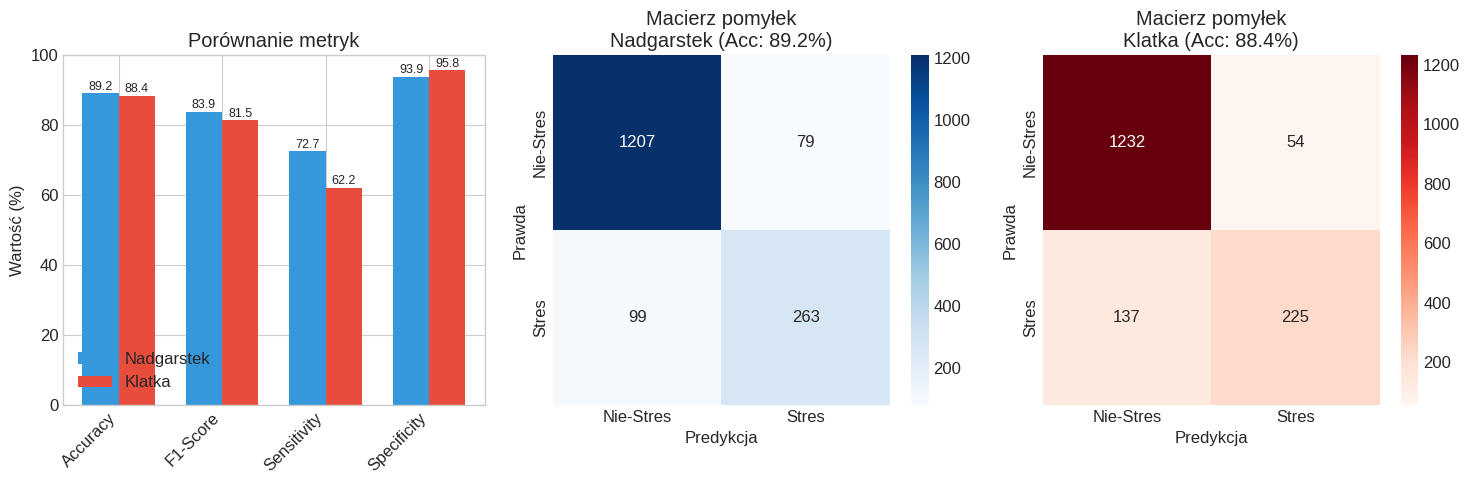

In [14]:
# Wizualizacja porównania
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Metryki
metrics = ['Accuracy', 'F1-Score', 'Sensitivity', 'Specificity']
wrist_vals = [results_wrist['accuracy'], results_wrist['f1_score'], 
              results_wrist['sensitivity'], results_wrist['specificity']]
chest_vals = [results_chest['accuracy'], results_chest['f1_score'],
              results_chest['sensitivity'], results_chest['specificity']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, [v*100 for v in wrist_vals], width, 
                    label='Nadgarstek', color='#3498db')
bars2 = axes[0].bar(x + width/2, [v*100 for v in chest_vals], width,
                    label='Klatka', color='#e74c3c')

axes[0].set_ylabel('Wartość (%)')
axes[0].set_title('Porównanie metryk')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 100)

# Dodaj wartości nad słupkami
for bar, val in zip(bars1, wrist_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f'{val*100:.1f}', ha='center', fontsize=9)
for bar, val in zip(bars2, chest_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{val*100:.1f}', ha='center', fontsize=9)

# 2. Confusion Matrix - Nadgarstek
sns.heatmap(results_wrist['cm'], annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Nie-Stres', 'Stres'], yticklabels=['Nie-Stres', 'Stres'])
axes[1].set_title(f"Macierz pomyłek\nNadgarstek (Acc: {results_wrist['accuracy']*100:.1f}%)")
axes[1].set_xlabel('Predykcja')
axes[1].set_ylabel('Prawda')

# 3. Confusion Matrix - Klatka
sns.heatmap(results_chest['cm'], annot=True, fmt='d', cmap='Reds', ax=axes[2],
            xticklabels=['Nie-Stres', 'Stres'], yticklabels=['Nie-Stres', 'Stres'])
axes[2].set_title(f"Macierz pomyłek\nKlatka (Acc: {results_chest['accuracy']*100:.1f}%)")
axes[2].set_xlabel('Predykcja')
axes[2].set_ylabel('Prawda')

plt.tight_layout()
plt.show()

In [15]:
# Różnica w dokładności
diff_acc = (results_chest['accuracy'] - results_wrist['accuracy']) * 100
diff_f1 = (results_chest['f1_score'] - results_wrist['f1_score']) * 100

print("\n" + "="*70)
print("📈 ANALIZA RÓŻNIC")
print("="*70)
print(f"""
🔍 Różnica Accuracy: {diff_acc:+.1f} punktów procentowych
   (Klatka {'lepsza' if diff_acc > 0 else 'gorsza'} od nadgarstka)

🔍 Różnica F1-Score: {diff_f1:+.1f} punktów procentowych
   (Klatka {'lepsza' if diff_f1 > 0 else 'gorsza'} od nadgarstka)

📊 Liczba cech:
   - Nadgarstek: {results_wrist['n_features']} cech
   - Klatka: {results_chest['n_features']} cech

💡 WNIOSKI:
   - Klatka piersiowa daje {'lepsze' if diff_acc > 0 else 'gorsze'} wyniki
   - Różnica {abs(diff_acc):.1f}% {'uzasadnia' if abs(diff_acc) > 5 else 'nie uzasadnia'} użycie niewygodnego sensora
   - Nadgarstek jest {'akceptowalną alternatywą' if results_wrist['accuracy'] > 0.7 else 'niewystarczający'} dla codziennego użytku
""")
print("="*70)


📈 ANALIZA RÓŻNIC

🔍 Różnica Accuracy: -0.8 punktów procentowych
   (Klatka gorsza od nadgarstka)

🔍 Różnica F1-Score: -2.4 punktów procentowych
   (Klatka gorsza od nadgarstka)

📊 Liczba cech:
   - Nadgarstek: 16 cech
   - Klatka: 19 cech

💡 WNIOSKI:
   - Klatka piersiowa daje gorsze wyniki
   - Różnica 0.8% nie uzasadnia użycie niewygodnego sensora
   - Nadgarstek jest akceptowalną alternatywą dla codziennego użytku



## 9. Podsumowanie

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                         PODSUMOWANIE                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  NADGARSTEK (Empatica E4 / Smartwatch):                             ║
║  ✓ Wygodny w codziennym użyciu                                       ║
║  ✓ Nieinwazyjny                                                      ║
║  ✗ Niższa częstotliwość próbkowania                                  ║
║  ✗ Optyczny BVP zamiast ECG                                          ║
║  ✗ Podatny na artefakty ruchu                                        ║
║                                                                       ║
║  KLATKA PIERSIOWA (RespiBAN):                                        ║
║  ✓ Wysoka jakość sygnału                                             ║
║  ✓ Bezpośrednie ECG                                                  ║
║  ✓ Dodatkowe sygnały (oddychanie)                                    ║
║  ✗ Niewygodny                                                        ║
║  ✗ Widoczny pod ubraniem                                             ║
║                                                                       ║
║  REKOMENDACJA:                                                        ║
║  → Dla badań naukowych: klatka piersiowa                             ║
║  → Dla codziennego monitoringu: nadgarstek (smartwatch)              ║
║                                                                       ║
╚══════════════════════════════════════════════════════════════════════╝
""")

# Zapisz wyniki
output_path = Path("/home/milosz/Desktop/studia/afektywna/Affective-Computing")
comparison.to_csv(output_path / 'chest_vs_wrist_comparison.csv', index=False)
print(f"\n✅ Wyniki zapisane: {output_path / 'chest_vs_wrist_comparison.csv'}")


╔══════════════════════════════════════════════════════════════════════╗
║                         PODSUMOWANIE                                  ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                       ║
║  NADGARSTEK (Empatica E4 / Smartwatch):                             ║
║  ✓ Wygodny w codziennym użyciu                                       ║
║  ✓ Nieinwazyjny                                                      ║
║  ✗ Niższa częstotliwość próbkowania                                  ║
║  ✗ Optyczny BVP zamiast ECG                                          ║
║  ✗ Podatny na artefakty ruchu                                        ║
║                                                                       ║
║  KLATKA PIERSIOWA (RespiBAN):                                        ║
║  ✓ Wysoka jakość sygnału                                             ║
║  ✓ Bezpośrednie ECG                           